# Space-time Analytics Lab 3
## Becky Davies, Gabi Murillo, Adam Mahood, Barry Price, Johannes Uhl
## November 2016
### Analysis of Brown Bear trajectories in Slovenia, 1993-1999

#### Content:

A. Introduction

B. Visualisation of the data using 2D maps

C. Analysis of seasonal effects on movement speed

D. Home range and interaction analysis

E. Concluding remarks

Note: The notebook takes a while to load completely, since several web-based APIs are used and the data volume is fairly large.

###  Introduction

This assignment used data from Movebank.org and is from a study on the coexistence of Eurasian brown bears (Ursus arctos arctos) and humans in a multi-use landscape in central Slovenia. A total of 22 animals were tagged with radio transmitters, and data was collected from 5/4/93-9/23/99. The study/habitat area was bisected by a portion of the A-1 Highway that stretches from the capital of Ljubljana, SW to the city of Razdrto. The highway was completed in 1972, is fenced on both sides and is four lanes wide. The Slovenian portion of the Yugoslav Wars was over prior to the initiation of the study. Two bears (Dinko and Klemen) ranged south into Croatia, but after the conflict had ended there.

The average Slovenian brown bear weighs between 220-330 lbs., is usually solitary, omnivorous, and mostly nocturnal, especially in areas with a high human presence. Plant food accounts for 70%-85% of diet; meat is 15%-30%. The bears can cover tens of kilometers per day and studies have shown more movement for both sexes during mating season from May-July, although sows with cubs don’t range as far during mating season, possibly due to infanticide concerns. There is much less movement from November-March during hibernation season. The bears are not full hibernators and can wake easily during this season.

In [26]:
#loading libraries:

import pandas as pd
import json
from IPython.display import Javascript
from IPython.display import HTML
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation
import random
%config InlineBackend.figure_format = 'svg'
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 9
%matplotlib inline
%pylab inline

import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('johannesuhl', '1xhtdlbk6o')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [27]:
#read the data
csvfile=r'./Data/Brown bear Slovenia 1993-1999UTM.csv'
df = pd.read_csv(csvfile) 
#make sure that you adjust your code to the pandas dataframe object df, we only want to read the data once.


### B. Visualisation of the data using 2D maps

In [28]:
#Converts a dataframe to a geojson Point output
def df_to_geojson_point(df, properties, lat, lon):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

#Converts a dataframe to a geojson LineString output
def df_to_geojson_line(df, ycoord, xcoord, aggregateBy):
    
    #create new dataframe, aggregate points per bear to a linestring:
    uniqueValues=[]
    for _, row in df.iterrows():
        uniqueValues.append(row[aggregateBy])
    
    
    uniqueValues=list(set(uniqueValues))    
    
    aggDFlist=[]
    for uniqueValue in uniqueValues:
        coords=[]
        for _, row in df.iterrows():
            if row[aggregateBy] == uniqueValue:
                currx = row[xcoord]
                curry = row[ycoord]
                #coords+=",["+str(currx)+","+str(curry)+"]"
                coords.append([row[xcoord],row[ycoord]])
        
        #coords="["+coords[1:]+"]"
        aggDFlist.append([uniqueValue,coords])
    
    
    
    aggr_df = pd.DataFrame(aggDFlist, columns=["bear_name", "coords"])  
    
    properties=["bear_name"]
    geojson = {"type":"FeatureCollection", "features":[]}
    for _, row in aggr_df.iterrows():
        feature = {"type":"Feature",
                   "properties":{},
                   "geometry":{"type":"LineString",
                               "coordinates": ""}}
        #print row["coords"]
        feature["geometry"]["coordinates"] = row["coords"]
        for prop in properties:
            feature["properties"][prop] = row[prop]
        geojson["features"].append(feature)
    return str(geojson).replace("'",'"')

In [29]:
properties=[]
properties.append('timestamp')
properties.append('time_index')
properties.append('individual-local-identifier')

#create time index
def createTimeIndex (row):
   index = row['timestamp'][:4]+row['timestamp'][5:7]+row['timestamp'][8:10]
   return index
df['time_index'] = df.apply(lambda row: createTimeIndex (row),axis=1)
#print df.head(10)

#get subset for bear
#df_subset = df[df['individual-local-identifier'] == 'dusan'] #[:20] #test, just first 20 points
df_subset = df

#get unique bear names:
#bears = set(list(df['individual-local-identifier']))
#print bears

#EDIT HERE PTS
geojson_points = df_to_geojson_point(df_subset, properties, 'location-lat', 'location-long')
#print geojson_points

#EDIT HERE LINES
geojson_lines = df_to_geojson_line(df_subset, 'location-lat', 'location-long', 'individual-local-identifier')
#print geojson_lines

#Javascript("""window.vizObj_lines1={};""".format(geojson_lines))
Javascript("""window.vizObj_points1={};""".format(geojson_points))

<IPython.core.display.Javascript object>

In [30]:
HTML("""
<link href='https://www.mapbox.com/base/latest/base.css' rel='stylesheet' />
<style> #map {
  position: relative;
  width: auto;
  height: 500px;
  overflow:visible;
}

#map2 {
  position: relative;
  width: auto;
  height: 500px;
  overflow:visible;
}

.legend {
    background-color: #fff;
    border-radius: 3px;
    bottom: 30px;
    box-shadow: 0 1px 2px rgba(0,0,0,0.10);
    font: 9px/10px 'Helvetica Neue', Arial, Helvetica, sans-serif;
    padding: 5px;
    position: absolute;
    right: 5px;
    z-index: 1;
}
.legend h4 {
    margin: 0 0 10px;
}
.legend div span {
    border-radius: 50%;
    display: inline-block;
    height: 10px;
    margin-right: 5px;
    width: 10px;
}
</style>

""")

In [31]:
%%javascript
require.config({
  paths: {
      mapboxgl: 'https://api.tiles.mapbox.com/mapbox-gl-js/v0.21.0/mapbox-gl',
      bootstrap: 'https://maxcdn.bootstrapcdn.com/bootstrap/3.3.6/js/bootstrap.min'
  }
});

<IPython.core.display.Javascript object>

In [51]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
require(['mapboxgl', 'bootstrap'], function(mapboxgl, bootstrap){
    mapboxgl.accessToken = 'pk.eyJ1Ijoiam9oYW5uZXN1aGwiLCJhIjoiY2l1dWJ4YndlMDJ5ZzJvbjBhNHAybnhxYSJ9.Tvsyxnah2xGhl9kfJnt8Yg';
    var map = new mapboxgl.Map({
        container: 'map', // container id
        style: 'mapbox://styles/mapbox/dark-v8', //stylesheet location
        center: [14.3031661581, 45.8698704914], // starting position
        zoom: 6 // starting zoom
    });

    function addSegLayerPoint(mapid) {
        //alert(window.vizObj_points.features[0].geometry.coordinates);
        try {  
            map.addSource("points", {
                "type": "geojson",
                "data": window.vizObj_points1
            });
            map.addLayer({
                "id": "points",
                "type": "symbol",
                "source": "points",
                "type": "circle",
                "paint": {
                    "circle-radius": 4,
                    "circle-color":{
                        property: 'individual-local-identifier',
                        type: 'categorical',
                        stops: [
                            ['mishko','#a6cee3'],
                            ['ancka','#1f78b4'],
                            ['milan','#b2df8a'],
                            ['clio','#33a02c'],
                            ['klemen','#fb9a99'],
                            ['vanja','#e31a1c'],
                            ['srecko','#fdbf6f'],
                            ['jana','#ff7f00'],
                            ['polona','#cab2d6'],
                            ['urosh','#6a3d9a'],
                            ['lucia','#ffff99'],
                            ['vera','#b15928'],
                            ['ivan','#7fc97f'],
                            ['nejc','#beaed4'],
                            ['jure','#fdc086'],
                            ['maja','#ffff99'],
                            ['dusan','#386cb0'],
                            ['dinko','#e41a1c'],
                            ['metka','#377eb8'],
                            ['vinko','#4daf4a'],
                            ['joze','#984ea3'],
                            ['janko','#ff7f00']]  
                    }
                } 
                
            }); 
            
        } catch (err) {
            console.log(err);
            alert(err);
        }
    };
    
    function addSegLayerLine(mapid) {
        // Mapbox GL JS Api - import segment
        //alert(window.vizObj_lines.features[0].geometry.coordinates[0]);
        
        var segment_src = new mapboxgl.GeoJSONSource({
            data: window.vizObj_lines1,  
            maxzoom: 18,
            buffer: 1,
            tolerance: 1
        });
        try {
            mapid.addSource('segment', segment_src);
            mapid.addLayer({
                id: 'segment',
                type: 'line',
                source: 'segment',
                paint: {
                    "line-opacity": 1,
                    "line-width": 0.5,
                    "line-color": '#ffffff'                        
                    }   
                }
            );
        } catch (err) {
            alert(err);
            console.log(err);
        }
    };

    map.once('style.load', function(e) {        
        addSegLayerLine(map);
        addSegLayerPoint(map);
        map.addControl(L.mapbox.legendControl()); //not working?
        //map.addControl(new mapboxgl.Navigation({  //not working?
           //position: 'top-left'
        //}));
        map.addControl(new mapboxgl.Navigation({position: 'top-left'}));
    });
    
    

    // Create a popup, but don't add it to the map yet.
    var popup = new mapboxgl.Popup({
        closeButton: false,
        closeOnClick: false
    });
    map.on('mousemove', function(e) {
        var features = map.queryRenderedFeatures(e.point, { layers: ['points'] });
        // Change the cursor style as a UI indicator.
        map.getCanvas().style.cursor = (features.length) ? 'pointer' : '';

        if (!features.length) {
            popup.remove();
            return;
        }
        var feature = features[0];
        // Populate the popup and set its coordinates
        // based on the feature found.
        popup.setLngLat(feature.geometry.coordinates)
            .setHTML(feature.properties.timestamp)
            .addTo(map);
    });     
    
    
});
element.append('<h4>This map shows the measured locations of the individual bears:</h4>');
element.append('<div id="map"></div>');
element.append("<div id='legend' class='legend'> \
    <h4>Trajectories of individual bears</h4> \
    <div><span style='background-color: #1f78b4'></span>ancka </div> \
    <div><span style='background-color: #33a02c'></span>clio  </div> \
    <div><span style='background-color: #e41a1c'></span>dinko </div> \
    <div><span style='background-color: #386cb0'></span>dusan </div> \
    <div><span style='background-color: #7fc97f'></span>ivan  </div> \
    <div><span style='background-color: #ff7f00'></span>jana  </div> \
    <div><span style='background-color: #ff7f00'></span>janko </div> \
    <div><span style='background-color: #984ea3'></span>joze  </div> \
    <div><span style='background-color: #fdc086'></span>jure  </div> \
    <div><span style='background-color: #fb9a99'></span>klemen</div> \
    <div><span style='background-color: #ffff99'></span>lucia </div> \
    <div><span style='background-color: #ffff99'></span>maja  </div> \
    <div><span style='background-color: #377eb8'></span>metka </div> \
    <div><span style='background-color: #b2df8a'></span>milan </div> \
    <div><span style='background-color: #a6cee3'></span>mishko</div> \
    <div><span style='background-color: #beaed4'></span>nejc  </div> \
    <div><span style='background-color: #cab2d6'></span>polona</div> \
    <div><span style='background-color: #fdbf6f'></span>srecko</div> \
    <div><span style='background-color: #6a3d9a'></span>urosh </div> \
    <div><span style='background-color: #e31a1c'></span>vanja </div> \
    <div><span style='background-color: #b15928'></span>vera  </div> \
    <div><span style='background-color: #4daf4a'></span>vinko </div> \
    </div>");
               

<IPython.core.display.Javascript object>

In [33]:
#Converts a dataframe to a geojson Point output
def df_to_geojson_point(df, properties, lat, lon):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

#Converts a dataframe to a geojson LineString output
def df_to_geojson_line(df, ycoord, xcoord, aggregateBy):
    
    #create new dataframe, aggregate points per bear to a linestring:
    uniqueValues=[]
    for _, row in df.iterrows():
        uniqueValues.append(row[aggregateBy])
    
    
    uniqueValues=list(set(uniqueValues))    
    
    aggDFlist=[]
    for uniqueValue in uniqueValues:
        coords=[]
        for _, row in df.iterrows():
            if row[aggregateBy] == uniqueValue:
                currx = row[xcoord]
                curry = row[ycoord]
                #coords+=",["+str(currx)+","+str(curry)+"]"
                coords.append([row[xcoord],row[ycoord]])
        
        #coords="["+coords[1:]+"]"
        aggDFlist.append([uniqueValue,coords])
    
    
    
    aggr_df = pd.DataFrame(aggDFlist, columns=["bear_name", "coords"])  
    
    properties=["bear_name"]
    geojson = {"type":"FeatureCollection", "features":[]}
    for _, row in aggr_df.iterrows():
        feature = {"type":"Feature",
                   "properties":{},
                   "geometry":{"type":"LineString",
                               "coordinates": ""}}
        #print row["coords"]
        feature["geometry"]["coordinates"] = row["coords"]
        for prop in properties:
            feature["properties"][prop] = row[prop]
        geojson["features"].append(feature)
    return str(geojson).replace("'",'"')

In [34]:
properties=[]
properties.append('timestamp')
properties.append('time_index')
properties.append('individual-local-identifier')

#create time index
def createTimeIndex (row):
   index = row['timestamp'][:4]+row['timestamp'][5:7]+row['timestamp'][8:10]
   return index
df['time_index'] = df.apply(lambda row: createTimeIndex (row),axis=1)
#print df.head(10)

#get subset for bear
#df_subset = df[df['individual-local-identifier'] == 'dusan'] #[:20] #test, just first 20 points
df_subset = df

#get unique bear names:
#bears = set(list(df['individual-local-identifier']))
#print bears

#EDIT HERE PTS
geojson_points = df_to_geojson_point(df_subset, properties, 'location-lat', 'location-long')
#print geojson_points

#EDIT HERE LINES
geojson_lines = df_to_geojson_line(df_subset, 'location-lat', 'location-long', 'individual-local-identifier')
#print geojson_lines



Javascript("""window.vizObj_points2={};""".format(geojson_points))
#Javascript("""window.vizObj_lines2={};""".format(geojson_lines))


<IPython.core.display.Javascript object>

In [52]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
require(['mapboxgl', 'bootstrap'], function(mapboxgl, bootstrap){
    mapboxgl.accessToken = 'pk.eyJ1Ijoiam9oYW5uZXN1aGwiLCJhIjoiY2l1dWJ4YndlMDJ5ZzJvbjBhNHAybnhxYSJ9.Tvsyxnah2xGhl9kfJnt8Yg';
    var map2 = new mapboxgl.Map({
        container: 'map2', // container id
        style: 'mapbox://styles/mapbox/dark-v8', //stylesheet location
        center: [14.3031661581, 45.8698704914], // starting position
        zoom: 6 // starting zoom
    });

    function addSegLayerPoint(mapid) {
        //alert(window.vizObj_points.features[0].geometry.coordinates);
        try {  
            map2.addSource("points", {
                "type": "geojson",
                "data": window.vizObj_points2
            });
            map2.addLayer({
                "id": "points",
                "type": "symbol",
                "source": "points",
                "type": "circle",
                "paint": {
                    "circle-radius": 4,
                    "circle-color":{
                        property: 'time_index',
                        stops: [
                            [19930000, '#d53e4f'],
                            [19940000, '#fc8d59'],
                            [19950000, '#fee08b'],
                            [19960000, '#ffffbf'],
                            [19970000, '#e6f598'],
                            [19980000, '#99d594'],
                            [19990000, '#3288bd'],
                        ]
                    }
                } 
                
            });    
        } catch (err) {
            console.log(err);
            alert(err);
        }
    };
    
    function addSegLayerLine(mapid) {
        // Mapbox GL JS Api - import segment
        //alert(window.vizObj_lines.features[0].geometry.coordinates[0]);
        
        var segment_src = new mapboxgl.GeoJSONSource({
            data: window.vizObj_lines2,  
            maxzoom: 18,
            buffer: 1,
            tolerance: 1
        });
        try {
            mapid.addSource('segment', segment_src);
            mapid.addLayer({
                id: 'segment',
                type: 'line',
                source: 'segment',
                paint: {
                    "line-opacity": 1,
                    "line-width": 0.5,
                    "line-color": '#ffffff'                        
                    }   
                }
            );
        } catch (err) {
            alert(err);
            console.log(err);
        }
    };

    map2.once('style.load', function(e) {        
        addSegLayerLine(map2);
        addSegLayerPoint(map2);
        map2.addControl(L.mapbox.legendControl()); //not working?
        map2.addControl(new mapboxgl.Navigation({  //not working?
            position: 'top-left'
        }));
    });

    
    
    
    // Create a popup, but don't add it to the map yet.
    var popup = new mapboxgl.Popup({
        closeButton: false,
        closeOnClick: false
    });
    map2.on('mousemove', function(e) {
        var features = map.queryRenderedFeatures(e.point, { layers: ['points'] });
        // Change the cursor style as a UI indicator.
        map2.getCanvas().style.cursor = (features.length) ? 'pointer' : '';

        if (!features.length) {
            popup.remove();
            return;
        }
        var feature = features[0];
        // Populate the popup and set its coordinates
        // based on the feature found.
        popup.setLngLat(feature.geometry.coordinates)
            .setHTML(feature.properties.timestamp)
            .addTo(map2);
    });    
    
    
    
    
    
});
element.append('<h4>This map shows the year in which the bears were measured:</h4>');
element.append('<div id="map2"></div>');
element.append("<div id='legend' class='legend'> \
    <h4>Bear locations by year</h4> \
    <div><span style='background-color: #d53e4f'></span>1993 </div> \
    <div><span style='background-color: #fc8d59'></span>1994 </div> \
    <div><span style='background-color: #fee08b'></span>1995 </div> \
    <div><span style='background-color: #ffffbf'></span>1996 </div> \
    <div><span style='background-color: #e6f598'></span>1997 </div> \
    <div><span style='background-color: #99d594'></span>1998 </div> \
    <div><span style='background-color: #3288bd'></span>1999 </div> \
    </div>");

<IPython.core.display.Javascript object>

### C. Analysis of seasonal effects on movement speed

In [36]:
#Gabi's code and results

In [37]:



def df_to_geojson_point(df, properties, lat, lon):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

#Converts a dataframe to a geojson LineString output
def df_to_geojson_line(df, ycoord, xcoord, aggregateBy):
    
    #create new dataframe, aggregate points per bear to a linestring:
    uniqueValues=[]
    for _, row in df.iterrows():
        uniqueValues.append(row[aggregateBy])
    
    
    uniqueValues=list(set(uniqueValues))    
    
    aggDFlist=[]
    for uniqueValue in uniqueValues:
        coords=[]
        for _, row in df.iterrows():
            if row[aggregateBy] == uniqueValue:
                currx = row[xcoord]
                curry = row[ycoord]
                #coords+=",["+str(currx)+","+str(curry)+"]"
                coords.append([row[xcoord],row[ycoord]])
        
        #coords="["+coords[1:]+"]"
        aggDFlist.append([uniqueValue,coords])
    
    
    
    aggr_df = pd.DataFrame(aggDFlist, columns=["bear_name", "coords"])  
    
    properties=["bear_name"]
    geojson = {"type":"FeatureCollection", "features":[]}
    for _, row in aggr_df.iterrows():
        feature = {"type":"Feature",
                   "properties":{},
                   "geometry":{"type":"LineString",
                               "coordinates": ""}}
        #print row["coords"]
        feature["geometry"]["coordinates"] = row["coords"]
        for prop in properties:
            feature["properties"][prop] = row[prop]
        geojson["features"].append(feature)
    return str(geojson).replace("'",'"')


In [38]:
properties=[]
properties.append('timestamp')
properties.append('time_index')
properties.append('individual-local-identifier')

#create time index
def createTimeIndex (row):
   index = row['timestamp'][:4]+row['timestamp'][5:7]+row['timestamp'][8:10]
   return index
df['time_index'] = df.apply(lambda row: createTimeIndex (row),axis=1)
#print df.head(10)

#compute speed between two vertices of each bears trajectory:

#get unique bear names:
bears = set(list(df['individual-local-identifier']))

geojson = {"type":"FeatureCollection", "features":[]}
for bear in bears:
    df_subset = df[df['individual-local-identifier'] == bear]
    for i in range(1, len(df_subset)):
        currx = df_subset.iloc[i]['utm-easting']
        curry = df_subset.iloc[i]['utm-northing']
        prevx = df_subset.iloc[i-1]['utm-easting']
        prevy = df_subset.iloc[i-1]['utm-northing']   
        dist_to_prev = np.sqrt((currx-prevx)**2+(curry-prevy)**2) / 1000.0 #in km
        time_to_prev = (pd.Timestamp(df_subset.iloc[i]['timestamp']) - pd.Timestamp(df_subset.iloc[i-1]['timestamp']))/ pd.Timedelta('1 hour') #in hrs.
        if time_to_prev!=0:
            speed_from_prev = float(dist_to_prev)/float(time_to_prev)
        else:
            speed_from_prev = 0.0

        feature = {"type":"Feature",
                   "properties":{},
                   "geometry":{"type":"LineString",
                               "coordinates": ""}}          
        
        currx_geog = df_subset.iloc[i]['location-long']
        curry_geog = df_subset.iloc[i]['location-lat']
        prevx_geog = df_subset.iloc[i-1]['location-long']
        prevy_geog = df_subset.iloc[i-1]['location-lat']          

        feature["geometry"]["coordinates"] = [[prevx_geog,prevy_geog],[currx_geog,curry_geog]]
        feature["properties"]["bear_name"] = bear
        feature["properties"]["speed_from_prev_kmh"] = speed_from_prev
        feature["properties"]["dist_to_prev_km"] = dist_to_prev
        feature["properties"]["time_to_prev_h"] = time_to_prev
        
        geojson["features"].append(feature)        
geojson = str(geojson).replace("'",'"')                                         

Javascript("""window.vizObj_lines_speed={};""".format(geojson))

<IPython.core.display.Javascript object>

In [39]:
HTML("""

<link rel="stylesheet" href="https://unpkg.com/leaflet@1.0.1/dist/leaflet.css" />
<style> 
#mapid { height: 500px; }

.legend {
    line-height: 18px;
    color: #555;
}
.legend i {
    width: 18px;
    height: 18px;
    float: left;
    margin-right: 8px;
    opacity: 0.7;
}

</style>

""")

In [40]:
%%javascript
require.config({
  paths: {
      leaflet: "https://unpkg.com/leaflet@1.0.1/dist/leaflet.js"
  }
});

<IPython.core.display.Javascript object>

In [53]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
require(['https://unpkg.com/leaflet@1.0.1/dist/leaflet.js'], function(leaflet){
//require(['leaflet'], function(leaflet){ //not working, why???
    
    var mymap = L.map('mapid').setView([45.86,14.30], 8);
    //var mymap2 = L.map('mapid2').setView([45.86,14.30], 8);
    var OpenStreetMap_Mapnik = L.tileLayer('http://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', {
        maxZoom: 19,
        attribution: '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>' });     
    //OpenStreetMap_Mapnik.addTo(mymap); 
    
    var CartoDB_DarkMatter = L.tileLayer('http://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png', {
        attribution: '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> &copy; <a href="http://cartodb.com/attributions">CartoDB</a>',
        subdomains: 'abcd',
        maxZoom: 19
    }); 
    CartoDB_DarkMatter.addTo(mymap); //alternative basemap from http://leaflet-extras.github.io/leaflet-providers/preview/

    
    var NASAGIBS_ViirsEarthAtNight2012 = L.tileLayer('http://map1.vis.earthdata.nasa.gov/wmts-webmerc/VIIRS_CityLights_2012/default/{time}/{tilematrixset}{maxZoom}/{z}/{y}/{x}.{format}', {
        attribution: 'Imagery provided by services from the Global Imagery Browse Services (GIBS), operated by the NASA/GSFC/Earth Science Data and Information System (<a href="https://earthdata.nasa.gov">ESDIS</a>) with funding provided by NASA/HQ.',
        bounds: [[-85.0511287776, -179.999999975], [85.0511287776, 179.999999975]],
        minZoom: 1,
        maxZoom: 8,
        format: 'jpg',
        time: '',
        tilematrixset: 'GoogleMapsCompatible_Level'
    });
    //NASAGIBS_ViirsEarthAtNight2012.addTo(mymap); //alternative basemap from http://leaflet-extras.github.io/leaflet-providers/preview/

    var OpenStreetMap_BlackAndWhite = L.tileLayer('http://{s}.tiles.wmflabs.org/bw-mapnik/{z}/{x}/{y}.png', {
        maxZoom: 18,
        attribution: '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a>'
    });
    //OpenStreetMap_BlackAndWhite.addTo(mymap2); //alternative basemap from http://leaflet-extras.github.io/leaflet-providers/preview/

    
    
    //var myLayer = L.geoJSON().addTo(mymap);
    //myLayer.addData(window.vizObj_lines_speed);
    //console.log(window.vizObj_lines_speed.features[0].properties.speed_from_prev_kmh)
    
    L.geoJSON(window.vizObj_lines_speed, {
        style: function(feature) {
            if (feature.properties.speed_from_prev_kmh >=0.0 && feature.properties.speed_from_prev_kmh <0.1) {return {color: "#fef0d9"}};
            if (feature.properties.speed_from_prev_kmh >=0.1 && feature.properties.speed_from_prev_kmh <0.2) {return {color: "#fdd49e"}};
            if (feature.properties.speed_from_prev_kmh >=0.2 && feature.properties.speed_from_prev_kmh <0.3) {return {color: "#fdbb84"}};
            if (feature.properties.speed_from_prev_kmh >=0.3 && feature.properties.speed_from_prev_kmh <0.4) {return {color: "#fc8d59"}};
            if (feature.properties.speed_from_prev_kmh >=0.4 && feature.properties.speed_from_prev_kmh <0.5) {return {color: "#ef6548"}};
            if (feature.properties.speed_from_prev_kmh >=0.5 && feature.properties.speed_from_prev_kmh <0.6) {return {color: "#d7301f"}};
            if (feature.properties.speed_from_prev_kmh >=0.6 && feature.properties.speed_from_prev_kmh <0.7) {return {color: "#990000"}};         }
    }).addTo(mymap);   //feature.properties.speed_from_prev not defined         
  
    var legend = L.control({position: 'bottomright'});

    legend.onAdd = function (map) {

        var div = L.DomUtil.create('div', 'info legend'),
            grades = [0, 10, 20, 50, 100, 200, 500, 1000],
            labels = [],
            from, to;

        for (var i = 0; i < grades.length; i++) {
            from = grades[i];
            to = grades[i + 1];

            labels.push(
                '<i style="background:' + getColor(from + 1) + '"></i> ' +
                from + (to ? '&ndash;' + to : '+'));
        }

        div.innerHTML = labels.join('<br>');
        return div;
    };

    legend.addTo(map);   
    


});
element.append('<h3> Average travel speed of all bears (yellow 0.1 kmh --> red 0.7 kmh)</h3>');
element.append('<div id="mapid"></div>');

<IPython.core.display.Javascript object>

### D. Home range and interaction analysis

The first part of the interaction analysis is done in R using wildlifeDI package.
The notebook requires a separate R kernel and therefore it could not be included here. 

It can be accessed here:

https://github.com/johannesuhl/STA-lab3/blob/master/Wildlife%20Trajectories%20in%20R.ipynb

#### Visualizing Space-Time Cube for paths of all brown bears in study using Plotly

TO DO (Becky):
- Label paths w/ bear names
- Add write up for plotly viz

In [42]:


def brownian_motion(T = 1, N = 100, mu = 0.1, sigma = 0.01, S0 = 20):
    dt = float(T)/N
    t = np.linspace(0, T, N)
    W = np.random.standard_normal(size = N)
    W = np.cumsum(W)*np.sqrt(dt) # standard brownian motion
    X = (mu-0.5*sigma**2)*t + sigma*W
    S = S0*np.exp(X) # geometric brownian motion
    return S

In [43]:
data = []
for tag in set(df['tag-local-identifier']):
    bear = df[df['tag-local-identifier'] == tag]

    y = pd.Series(bear['utm-easting'])
    x = pd.Series(bear['utm-northing'])
    dates = pd.to_datetime(bear['timestamp'])

    trace = go.Scatter3d(
        x=x, y=y, z=dates,
        marker=dict(
            size=4,
            color="#%06x" % random.randint(0, 0xFFFFFF),
            colorscale='Viridis',
        ),
        line=dict(
            color = '#444ddd',
            width=1
        )
    )

    data.append(trace)
    
layout = dict(
    width=800,
    height=700,
    autosize=False,
    title='Bears movement Slovenia',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        ),
        camera=dict(
            up=dict(
                x=0,
                y=0,
                z=1
            ),
            eye=dict(
                x=-1.7428,
                y=1.0707,
                z=0.7100,
            )
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'
    ),
)
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='bears_slovenia_test', height=1200, validate=False)

#### Examining spatial-temporal interaction of bears between each other

TO DO (Becky):
- finish looping through locations to check for nearness
- visualize nearby points in space-time
- write up for interaction test


In [44]:
def find_interval(x):
    start = np.datetime64(x) + np.timedelta64(-12, 'h')
    end = np.datetime64(x) + np.timedelta64(12, 'h')
    return start, end
def check_interval(x, start, end):
    x = np.datetime64(x)
    return start< x < end

In [45]:
# for each bear in data set
for bear in set(df['tag-local-identifier']):
    focal_bear = df[df['tag-local-identifier'] == bear]
    print bear
    # isolate points for single bear
    focal_bear = df[df['tag-local-identifier'] == bear]
    # from timestamps, find time interval to examine interaction
    focal_bear['interval'] = focal_bear.timestamp.apply(find_interval)
    #search all other data timestamps for presence in interval
    other_bears = df[df['tag-local-identifier'] != bear] 
    r = other_bears.timestamp.apply(check_interval, args=(focal_bear.interval.values[0][0],focal_bear.interval.values[0][1]))
    # for matching timestamps at point, search all locations for present within radius
    
    if len(r[r==True]) > 0:
        print('MATCH')
    else:
        print('no matches')

mishko


C:\Users\Johannes\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



MATCH
ancka
MATCH
milan
no matches
clio
MATCH
klemen
MATCH
vanja
MATCH
srecko
MATCH
jana
no matches
polona
MATCH
urosh
no matches
lucia
MATCH
vera
no matches
ivan
MATCH
nejc
MATCH
jure
no matches
maja
no matches
dusan
MATCH
dinko
MATCH
metka
no matches
vinko
MATCH
joze
no matches
janko
MATCH


### Kernel density maps for each bear and for each year

First, a Kernel density map of all measurements together:


In [47]:
#create time index
def createTimeIndex (row):
   index = row['timestamp'][:4]+row['timestamp'][5:7]+row['timestamp'][8:10]
   return int(index)
df['time_index'] = df.apply(lambda row: createTimeIndex (row),axis=1)

def createYear (row):
   index = row['timestamp'][:4]
   return int(index)
df['year'] = df.apply(lambda row: createYear (row),axis=1)

df['bear'] = df['individual-local-identifier']

#get unique bear names:
bears = set(list(df['individual-local-identifier']))

Measurement density for all bears in 1993-1999


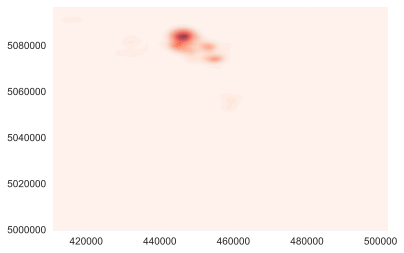

In [49]:
eastings = np.array(df['utm-easting'].tolist())
northings = np.array(df['utm-northing'].tolist())   
print 'Measurement density for all bears in 1993-1999'
fig, ax = plt.subplots()
kdens = sns.kdeplot(np.array(df['utm-easting'].tolist()), np.array(df['utm-northing'].tolist()), cmap="Reds", shade=True, legend=True, n_levels=30)
kdens.set(xlim=(411000, 502000))
kdens.set(ylim=(5000100, 5097000))
sns.plt.show()

### Faceted kernel density rasters for each bear and each yearly time slice

This allows for visually detecting which bears were active in which region and in which year:
(scroll to the right at the bottom to see all years!)

(5000100, 5097000)

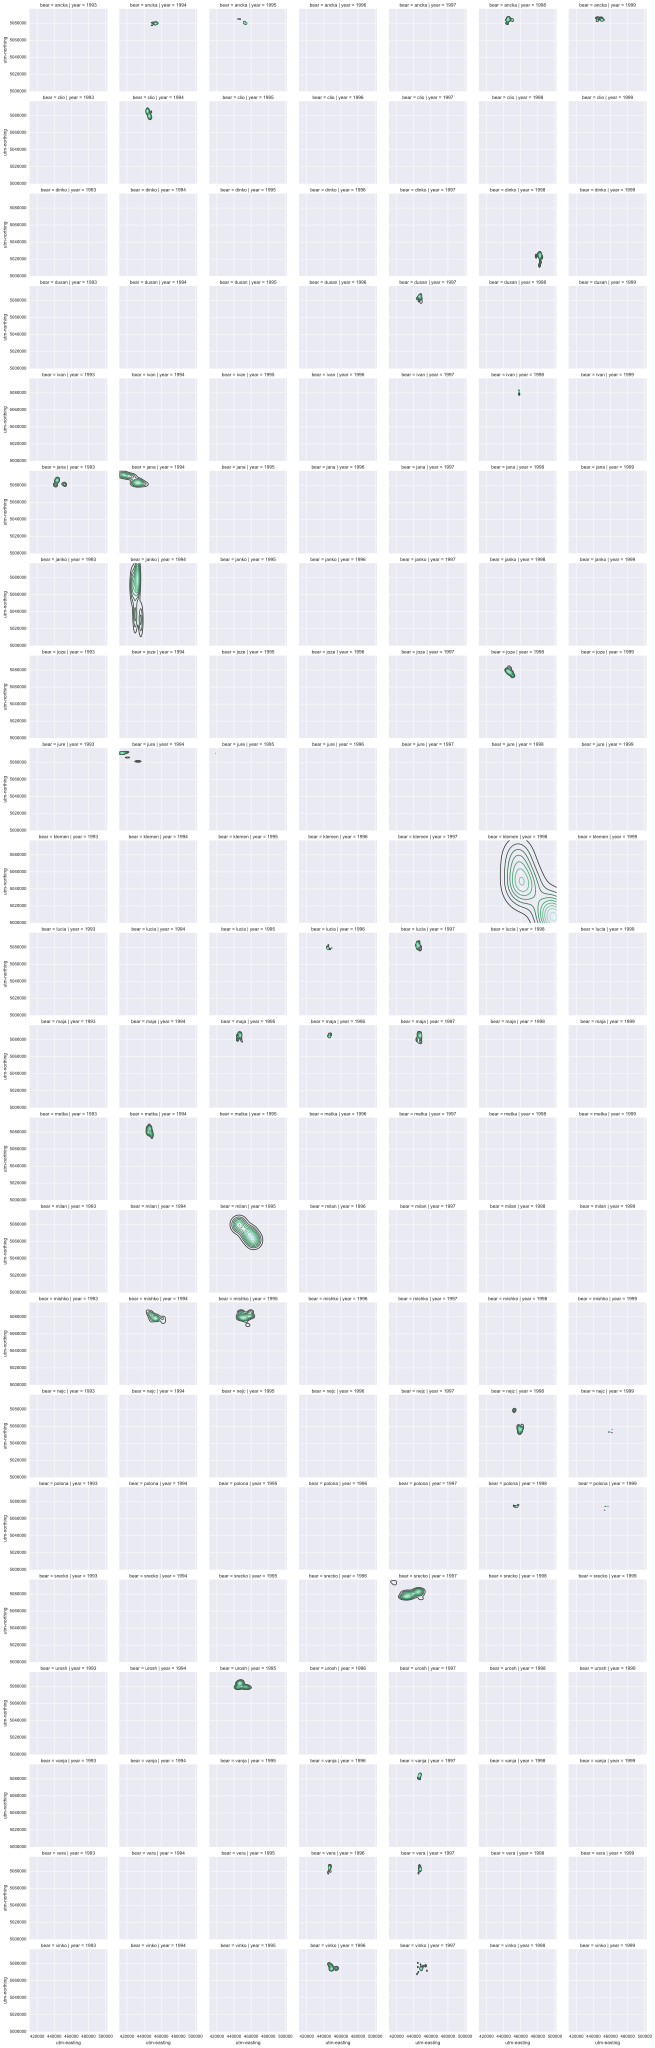

In [48]:

g = sns.FacetGrid(df, col="year", row='bear')  
g.map(sns.kdeplot, 'utm-easting', 'utm-northing')  
plt.xlim(411000, 502000)
plt.ylim(5000100, 5097000)


### E. Concluding remarks

It was an interesting lab and we learned a lot about bears in Slovenia, about data visualization in Jupyter using different techniques and visualization methods.